In [30]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [31]:
# Creaiamo una funzione di utilità per il plot delle gaussiane stimate

def plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data):
    plt.figure(figsize=(7,7))
    
    plt.minorticks_on()
    
    x = np.linspace(mu - 3 *sigma, mu + 3 * sigma, 500)
    
    y = multivariate_normal([mu], [sigma**2])
    y_hat = multivariate_normal([mu_hat],[sigma2_hat])
    
    plt.scatter(data, np.zeros((num_data,)), marker='x', c='r', label='Campioni')
    plt.plot(x, y.pdf(x), label='Distribuzione teorica')
    plt.plot(x,y_hat.pdf(x),label='Distribuzione stimata')
    
    mse = np.sum((y.pdf(data)-y_hat.pdf(data))**2)/num_data
    
    plt.text(-0.6, 0.45,\
            f'Media stimata: {mu_hat:4.2f}\nVarianza stimata: {sigma2_hat:4.2f}\nMSE: {mse:6.4f}',\
            fontsize=12)
    
    plt.legend()
    
    plt.show()

In [32]:
# Definiamo mu e sigma e num_data
mu = 1.5
sigma = 0.7
num_data = 100

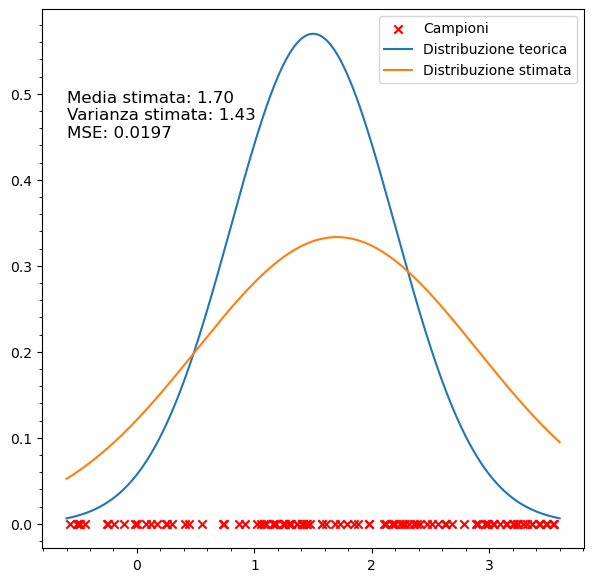

In [33]:
# Campionamento uniforme
rg = default_rng()

data = rg.uniform(mu - 3*sigma, mu + 3*sigma, num_data)

def uniform_estimate(data, num_data):
    
    mu_hat = np.sum(data)/num_data
    
    sigma2_hat = np.sum((data - mu_hat)**2)/(num_data - 1)
    
    return (mu_hat, sigma2_hat)

mu_hat, sigma2_hat = uniform_estimate(data, num_data)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)

In [34]:
# Eseguiamo una simulazione stimando più volte i valori
# di media e varianza per vedere quanto valgono in valore atteso

simulations = 100

mhs = np.zeros((simulations,), dtype=np.float64)
sigmahs = np.zeros((simulations,), dtype=np.float64)

for i in range(simulations):
    
    data = rg.uniform(mu - 3*sigma, mu + 3*sigma, num_data)
    
    mhs[i], sigmahs[i] = uniform_estimate(data, num_data)

mh = np.sum(mhs)/simulations
sh = np.sum(sigmahs)/simulations

print(f'Valore atteso della media: {mh:4.2f}\nValore atteso della varianza: {sh:4.2f}')

Valore atteso della media: 1.51
Valore atteso della varianza: 1.46


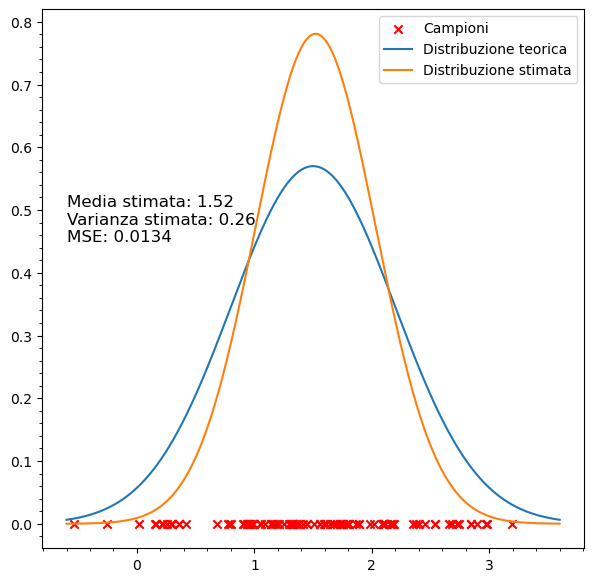

Varianza dello stimatore di media: 0.00043


In [40]:
# Campionamento stratificato usando come strati 
# gli intervalli di ampiezza sigma di una gaussiana

# S_k/S per k = 1, ..., 6
population_per_stratum = np.array([0.031, 0.136, 0.341, 0.341, 0.136, 0.031])

num_strata = 6

# Lista del numero dei campioni per strato n_k per k = 1, ..., 6
samples_per_stratum = np.array(num_data*population_per_stratum,dtype=int)

# Soluzione da adottare per avere n_k = costante
#samples_per_stratum = np.full((6,),2,dtype='int')

def stratified_estimate(num_strata, population_per_stratum, samples_per_stratum):
    
    data = np.empty((num_data,),dtype=np.float64)
    
    mu_per_stratum = np.empty((num_strata,),dtype='float64')
    sigma2_per_stratum = np.empty((num_strata,),dtype='float64')
    
    i = 0
    start = mu - 3*sigma
    
    # ci muoviamo strato per strato
    for k in range(0,len(samples_per_stratum)):
        
        data[i:i+samples_per_stratum[k]] = rg.uniform(start, start+sigma, samples_per_stratum[k])
        
        # stimiamo media e varianza di strato
        mu_per_stratum[k] = np.sum(data[i:i+samples_per_stratum[k]])/samples_per_stratum[k]
        sigma2_per_stratum[k] = np.sum((data[i:i+samples_per_stratum[k]]-mu_per_stratum[k])**2)\
                                            /(samples_per_stratum[k]-1)
                                    
        i = i + samples_per_stratum[k]
        start += sigma
    # Sommatoria con k di (S_k/S)*mu_k
    mu_hat = np.sum(population_per_stratum*mu_per_stratum)
    
    sigma2_hat = np.sum(sigma2_per_stratum)
    
    # Varianza dello stimatore di media
    var_mu_hat = np.sum((population_per_stratum**2)*sigma2_per_stratum/samples_per_stratum)
    
    return (mu_hat, sigma2_hat, var_mu_hat, data)

mu_hat, sigma2_hat, var_mu_hat, data = stratified_estimate(num_strata,\
                                                        population_per_stratum,\
                                                        samples_per_stratum)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)

print(f'Varianza dello stimatore di media: {var_mu_hat:7.5f}')

In [41]:
# Simulazione su 100 run del campionamento stratificato
mhs = np.zeros((simulations,), dtype=np.float64)
sigmahs = np.zeros((simulations,), dtype=np.float64)

for i in range(simulations):
        
    mhs[i], sigmahs[i], _, _ = stratified_estimate(num_strata, population_per_stratum, samples_per_stratum)

mh = np.sum(mhs)/simulations
sh = np.sum(sigmahs)/simulations

print(f'Valore atteso della media: {mh:4.2f}\nValore atteso della varianza: {sh:4.2f}')

Valore atteso della media: 1.52
Valore atteso della varianza: 0.25


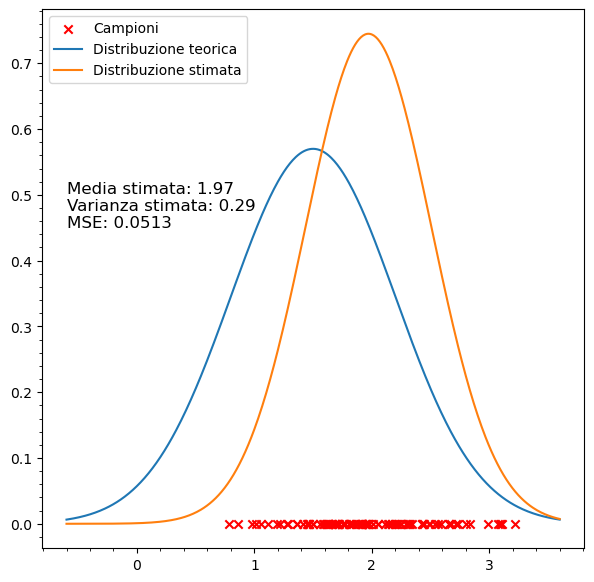

In [51]:
# Campionamento per importanza

def importance_estimate(num_data, scaling):
    
    rg = default_rng()
    
    # Estraggo i campioni per la funzione importanza con distribuzione uniforme
    samples_importance = rg.uniform(mu - 3 * sigma, mu + 3 * sigma, num_data)
    
    # Calcolo i parametri della funzione importanza come stime campionarie
    # sui valori estratti tramite distribuzione uniforme
    mu_importance = np.sum(samples_importance)/num_data
    
    sigma2_importance = np.sum((samples_importance-mu_importance)**2)/(num_data-1)
    
    # Campiono i dati per la stima tramite la funzione importanza
    data = rg.normal(mu_importance, scaling*np.sqrt(sigma2_importance),num_data)
    
    # Stimo media e varianza dei dati
    mu_hat = np.sum(data)/num_data
    sigma2_hat = np.sum((data - mu_hat)**2)/(num_data-1)
    
    return (mu_hat, sigma2_hat, data)


mu_hat, sigma2_hat, data = importance_estimate(num_data, 0.5)

plot_esimate(mu, sigma, mu_hat, sigma2_hat, data, num_data)  